# Model Interpretability

## Feature Selection

In this notebook, we will try to open the black box of our learned models and explore how our models "think" in regards to our data. This will help us see if our model is free of any aggregious errors in what it learned and will help us perform feature importance/selection to hopefully boost the performance of our best model so far. 

In this notebook, we will look at a few strategies of viewing model interpretability. First, we will look at scikit-learn's implementation of feature importance and note how there are some potential pitfalls when using its functions. We will compare its feature importance method with other methods and compare the results. 

Next, we will look at how values of our features affect the model's output by looking at some Partial Dependence Plots. We'll look at what they are and how to interpret them, which will help in interpreting how our model is thinking with our data.

Lastly, we'll look at a powerful library that can do all of the above, named Shap. This will help uncover even deeper the inner workings of our models. Let's begin.


In [1]:
!git clone https://github.com/BA545-SP2019/2019-competition2-3-musketeers.git


fatal: destination path '2019-competition2-3-musketeers' already exists and is not an empty directory.


In [2]:
%cd 2019-competition2-3-musketeers/Kevin/

/content/2019-competition2-3-musketeers/Kevin


In [3]:
!pip install eli5

In [4]:
!pip install pdpbox

In [5]:
!pip install shap

Load all of our dependcies. 

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats
sns.set()
%matplotlib inline
from Modules import *
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import xgboost as xgb
import eli5


In [7]:
#load in our final dataframe
df = pd.read_csv('Data/Final_trimmed_sequential_data.csv', index_col= 0)
df.head()

AGE  Y  SEX_Female  SEX_Male  EDUCATION_Graduate School  EDUCATION_Other  \
0   24  1           1         0                          0                0   
1   26  1           1         0                          0                0   
2   34  0           1         0                          0                0   
3   37  0           1         0                          0                0   
4   57  0           0         1                          0                0   

   EDUCATION_University  MARRIAGE_Married  MARRIAGE_Non-married  \
0                     1                 1                     0   
1                     1                 0                     1   
2                     1                 0                     1   
3                     1                 1                     0   
4                     1                 1                     0   

   PERCENT_OF_LIMIT_BAL1  ...  PAY_4_Other  PAY_4_more_than_two_month_late  \
0               0.195650  ...            0                               0   
1               0.022350  ...            1                               0   
2               0.308011  ...            1                               0   
3               0.899800  ...            1                               0   
4               0.132340  ...            1                               0   

   PAY_4_on_time  PAY_4_one_month_late  PAY_5_Other  \
0              1                     0            1   
1              0                     0            1   
2              0                     0            1   
3              0                     0            1   
4              0                     0            1   

   PAY_5_more_than_two_month_late  PAY_5_on_time  PAY_6_Other  \
0                               0              0            1   
1                               0              0            0   
2                               0              0            1   
3                               0              0            1   
4                               0              0            1   

   PAY_6_more_than_two_month_late  PAY_6_on_time  
0                               0              0  
1                               1              0  
2                               0              0  
3                               0              0  
4                               0              0  

[5 rows x 53 columns]

## Scikit-Learn implementation

### Comparison to RFE

To start the process of feature selection, we'll set a baseline using scikit_learn's `RFE` function, which uses recursive feature elimination to create a subset of the best 50% of features for our xgboost model. This will serve as a comparison to the various strategies we'll use to inspect important features. 



 

In [0]:
#set up our model and train/test split
from sklearn.externals import joblib

Train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 2019)

target = 'Y'
predictors = [x for x in Train_data.columns if x not in [target]]

loaded_model = joblib.load('Models/xgboost3.dat')


In [9]:
#show the test results, ensure model works
y_pred = loaded_model.predict(test_data[predictors])
print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred)}")
print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred)}")
print(f"Test F1: {metrics.f1_score(test_data[target], y_pred)}")




Test Accuracy: 0.7846666666666666
Test AUC: 0.7103046462252506
Test F1: 0.5365853658536585


In [0]:
#find the important features from the test data
#use RFE to get top 25 features.
from sklearn.feature_selection import RFE

selector = RFE(estimator=loaded_model, n_features_to_select=25, step=1)

selector.fit(Train_data[predictors], Train_data[target])

rankings = selector.ranking_


In [11]:
#show the top 25 features:
#any feature with rank 1 is selected by RFE
predictors_rfe = []
for feature, rank in zip(Train_data[predictors].columns, rankings):
    if rank == 1:
        predictors_rfe.append(feature)
        print(feature, rank)
    else:
        pass

AGE 1
SEX_Female 1
EDUCATION_Graduate School 1
MARRIAGE_Married 1
PERCENT_OF_LIMIT_BAL1 1
PERCENT_OF_LIMIT_BAL2 1
PERCENT_OF_LIMIT_BAL3 1
PERCENT_OF_LIMIT_BAL4 1
PERCENT_OF_LIMIT_BAL5 1
PERCENT_OF_LIMIT_BAL6 1
PAY_RATIO_2 1
PAY_RATIO_3 1
PAY_RATIO_4 1
PAY_RATIO_5 1
PAY_RATIO_6 1
PAY_RATIO_2_INDICATOR 1
PAY_RATIO_4_INDICATOR 1
PAY_1_Other 1
PAY_1_more_than_two_month_late 1
PAY_1_one_month_late 1
PAY_2_more_than_two_month_late 1
PAY_3_more_than_two_month_late 1
PAY_4_more_than_two_month_late 1
PAY_5_more_than_two_month_late 1
PAY_6_more_than_two_month_late 1


These are the features selected by the RFE function. It looks like the ratio of payment to bill amount, the ratio of outstanding balance to a clien't limit balance, and payment timing of more than __two__ months late are the most informative. 

With this in mind, we'll now turn our attention to other ways of detecting feature importance, especially for tree-based algorithms.  We first want to highlight the `feature_importance` function that scikit learn implements for such family of models. We will show that the results are not always consistent. We'll use our loaded xgboost model and use the `feature_importance` function and compare the results with xgboost's own implementation of `plot_importance`, and finally look at another method of feature importance to compare.

Now, we'll look at the feature importance scores for this model using scikit-learn's api. For convenience sake, we'll use the top 50% of features.


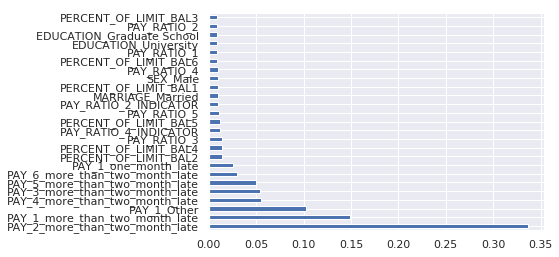

In [12]:
importances = pd.Series(loaded_model.feature_importances_, index=test_data[predictors].columns)
importances.nlargest(25).plot(kind='barh')

From this chart, we can see that the most important feature in the model are  `PAY_1_more_than_two_months_late`, `PERCENT_OF_LIMIT_BAL2`, and `PERCENT_OF_LIMIT_BAL1`  Then, there are some features that have a similar importance to each other, such as his or her age, and then their payment ratio history. It seems that the only feature describing the timing  of payments that is important is the most recent month's payment timing. After that, the ratio of a client's payment to his or her bill, along with the ratio of his or her oustanding balance compared to the balance limit are the more important features. Wholistically, payment patterns appear to be most important; it's all about the money!

This, of course, is useful, but one question that the modeler needs to always ask themselves is how much can he or she trust these findings? First off, do these findings make sense? Is age, according to the scores, really a high ranking important attribute about a customer? Second of all, we don't know for sure how the values of the features impact the model's thinking. For instance, could it be that the model acutally found that younger customers had a _lower_ chance of defaulting, when in the real world it could be the complete opposite? If this were the case, one would not have complete trust that this model is learning the appropriate patterns in the data; it might be performing well due to false findings.

What is important is to remember how sklearn implements feature importance; it does so by calculating the decrease in mean impurity. When training a tree, what is computed is how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. However, there are some problems with this method. For one, the model can be biased in selected features with more categories. Secondly, correlated features' importance scores may be incorrect; for two or more correlated features, from the point of view from the model, any of  correlated features can be used as a predictor, with no significant 'preference' between them. However, once one of the correlated features is used, the importance of the other features are reduced, since the level of impurity that the latter correlated features can reduce has, in fact, already been reduced by that first correated feature, resulting in a lower importance score for the latter correlated features.


In order to ensure our models findings, we'll compare these scores with two other mehods of calculating feature importances: xgboost library's own `plot_importances` function, and a library named ELI5, which will conduct permutated feature importance.
In xgboost's function, one can specify one of three methods of calculating the importance score: "weight" is the number of times a feature appears in a tree, "gain" is the average gain of splits which use the feature, "cover" is the average coverage of splits which use the feature. "weight" will give the exact same importances as the scikit-learn function does, so we will demonstrate the 'gain' method, and compare results.



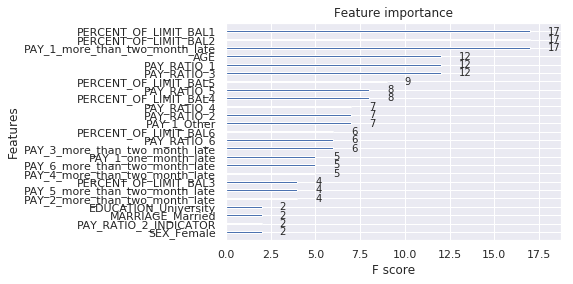

In [13]:
xgb.plot_importance(loaded_model, max_num_features=25, importance_type='weight')

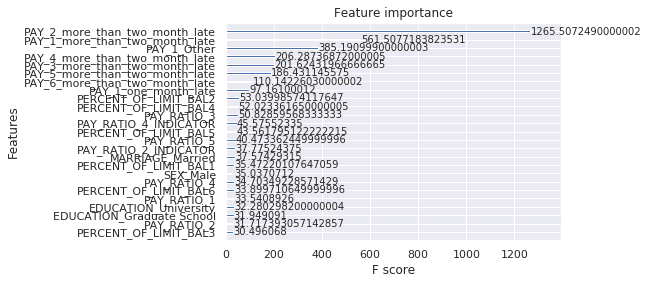

In [14]:
#xgboost 'gain' method
xgb.plot_importance(loaded_model, max_num_features=25,importance_type='gain')

This chart shows that the most important features are essentially opposite of the first chart; the timing of payments for each period is wholistically the most important. Additionally, it appears that only a certain amount of features are useful: the top 8 features, from 'PAY_2_more_than_two_month_late' to 'PAY_1_one_month_late'. WHAT DOES THIS MEAN? 

With this in mind, we'll introduce another method of feature importance. This method involves is called "permutation importance", or "Mean Decrease in Accuracy". Essentially, feature importance in this method is measured by inspecting how much our unit of measure ("accuracy, R^2, etc.) decreases when a certain feature is not available. This can be done by removing a feature and retraining an estimator one at a time, and record the unit of meausure, but this is computatationally expensive.

To remedy this problem, a better solution is to remove a feature only from the test set of our data, and compute the score without using this feature. Of course, our estimator expects the same corresponding features in the training and test split, so to "remove" the feature from the test set, we shuffle the values of that feature with values of other examples within that feature. This will in essence introduce noise to that feature, and using those noisty values, we can then inspect the decrease in accuracy when using that noisy feature; the bigger the drop in accuracy, the larger the importance. 

While this can be done natively with python, we'll use the  ELI5 library, which has a handy `PermutationImportance` function that will perform the above steps. Let's see how this works.

In [15]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(loaded_model).fit(test_data[predictors], test_data[target])
eli5.show_weights(perm, feature_names = list(predictors), top=25)

The output is intuitive enough; our important variables seem to be the payment timimg, similar to the results xgboost 'gain' method of calculating feature importance, with some contribution from a client's two most recent ratios of outstanding balance to his or her limit balance.   In fact, it seems that the only variables that add any benefit are from `PAY_1_more_than_two_month_late` to `SEX_Female`; all other features add no signal to our model, as shown by the value of 0 for weight for all features below `AGE`.  


### So what do we have?

In all, we looked at three ways of interpreting our xgboost model: scikit-learn's `feature_importance_` funciton, xgboost's `plot_importance` function, and ELI5 `PermutationImportance` function, and compared to the results of our baseline RFE function results. Each shows a different combination of important features, with some methods, like Permutation Importance, showing only a handful of features actually matter. There is no way of knowing which method works best for us in our case, so we'll experiment with all of the methods and see if any can boost our scores with all of the features being used.   

## RFE feature elimination

Let's make a helper function to run the entire process and print out the results.

In [0]:
def rfe_selector(model, n_select, Train_data, test_data):
    from sklearn.feature_selection import RFE
    target = 'Y'

    selector = RFE(estimator=model, n_features_to_select=n_select, step=1)

    selector.fit(Train_data[predictors], Train_data[target])

    rankings = selector.ranking_
    
    predictors_rfe = []
    for feature, rank in zip(Train_data[predictors].columns, rankings):
        if rank == 1:
            predictors_rfe.append(feature)
        
    else:
        pass
    
    model.fit(Train_data[predictors_rfe], Train_data[target])

    y_pred_rfe = loaded_model.predict(test_data[predictors_rfe])

    print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred_rfe)}")
    print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred_rfe)}")
    print(f"Test F1: {metrics.f1_score(test_data[target], y_pred_rfe)}")
    print(f"Features used: {predictors_rfe}")
    
    

In [17]:
#get the results for best 20, 15, 10 features
for n in [20, 15, 10]:
    print(f"Results with {n} best features:")
    rfe_selector(model=loaded_model, n_select=n, Train_data=Train_data, test_data=test_data)
    print()

Results with 20 best features:
Test Accuracy: 0.781
Test AUC: 0.7085320693230633
Test F1: 0.533049040511727
Features used: ['EDUCATION_Graduate School', 'PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL6', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_5', 'PAY_RATIO_6', 'PAY_RATIO_4_INDICATOR', 'PAY_1_Other', 'PAY_1_more_than_two_month_late', 'PAY_1_one_month_late', 'PAY_2_more_than_two_month_late', 'PAY_3_more_than_two_month_late', 'PAY_4_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late']

Results with 15 best features:
Test Accuracy: 0.7828333333333334
Test AUC: 0.7108255567076484
Test F1: 0.5364638918534329
Features used: ['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5', 'PAY_RATIO_3', 'PAY_RATIO_4_INDICATOR', 'PAY_1_Other', 'PAY_1_more_than_two_month_late', 'PAY_1_one_month

# Scikit_Learn implementaton:

As we can see, the results do get worse with each iteration, which may not bode well for other selection methods. Anyways, let's try it now with scikit_learn's `feature_importance_` function.

In [18]:
results = pd.DataFrame(np.zeros(shape = (len(range(1, 25, 3)),4)), columns = ['accuracy', 'auc', 'f1', 'predictors_used'])
results




accuracy  auc   f1  predictors_used
0       0.0  0.0  0.0              0.0
1       0.0  0.0  0.0              0.0
2       0.0  0.0  0.0              0.0
3       0.0  0.0  0.0              0.0
4       0.0  0.0  0.0              0.0
5       0.0  0.0  0.0              0.0
6       0.0  0.0  0.0              0.0
7       0.0  0.0  0.0              0.0

In [0]:
#make a dataframe of all features used and their corresponding metrics

#reminder: importances = pd.Series(loaded_model.feature_importances_, index=Train_data[predictors].columns)

results = pd.DataFrame(np.zeros(shape = (len(range(1, 25)),4)), columns = ['accuracy', 'auc', 'f1', 'predictors_used'])

for n in range(1, 25):
    predictors_skl = list(importances.nlargest(n).index)
    loaded_model.fit(Train_data[predictors_skl], Train_data[target])

    y_pred_skl = loaded_model.predict(test_data[predictors_skl])

    accuracy = metrics.accuracy_score(test_data[target], y_pred_skl)
    results.loc[n, 'accuracy'] = accuracy
    
    auc = metrics.roc_auc_score(test_data[target], y_pred_skl)
    results.loc[n, 'auc'] = auc
    
    f1 = metrics.f1_score(test_data[target], y_pred_skl)
    results.loc[n, 'f1'] = f1
    
    results.loc[n, 'predictors_used'] = str(predictors_skl[:])
    



In [20]:
results

accuracy       auc        f1  \
0   0.000000  0.000000  0.000000   
1   0.805333  0.650294  0.455224   
2   0.816833  0.697302  0.533729   
3   0.816833  0.697302  0.533729   
4   0.800667  0.708112  0.540707   
5   0.808167  0.709231  0.545598   
6   0.806000  0.709258  0.544601   
7   0.805500  0.710628  0.546091   
8   0.780500  0.706244  0.530146   
9   0.787167  0.707957  0.534791   
10  0.776333  0.705841  0.528129   
11  0.777667  0.708942  0.532258   
12  0.778667  0.709579  0.533380   
13  0.780500  0.709902  0.534464   
14  0.780167  0.708283  0.532435   
15  0.780333  0.709796  0.534276   
16  0.780167  0.708846  0.533097   
17  0.780333  0.706700  0.530627   
18  0.783167  0.709631  0.535191   
19  0.783167  0.711038  0.536846   
20  0.781667  0.707831  0.532477   
21  0.784667  0.708897  0.534917   
22  0.785167  0.712875  0.539807   
23  0.783167  0.709631  0.535191   
24  0.781333  0.707056  0.531429   

                                      predictors_used  
0                                                   0  
1                  ['PAY_2_more_than_two_month_late']  
2   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
3   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
4   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
5   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
6   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
7   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
8   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
9   ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
10  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
11  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
12  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
13  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
14  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
15  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
16  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
17  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
18  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
19  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
20  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
21  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
22  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
23  ['PAY_2_more_than_two_month_late', 'PAY_1_more...  
24  ['PAY_2_more_than_two_month_late', 'PAY_1_more...

In [21]:
predictors_bestskl = (results.iloc[22]['predictors_used'])

print(predictors_bestskl)

['PAY_2_more_than_two_month_late', 'PAY_1_more_than_two_month_late', 'PAY_1_Other', 'PAY_4_more_than_two_month_late', 'PAY_3_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late', 'PAY_1_one_month_late', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL4', 'PAY_RATIO_3', 'PAY_RATIO_4_INDICATOR', 'PERCENT_OF_LIMIT_BAL5', 'PAY_RATIO_5', 'PAY_RATIO_2_INDICATOR', 'MARRIAGE_Married', 'PERCENT_OF_LIMIT_BAL1', 'SEX_Male', 'PAY_RATIO_4', 'PERCENT_OF_LIMIT_BAL6', 'PAY_RATIO_1', 'EDUCATION_University']


The best comibination of AUC and F1 resulted from using the features in `predictors_bestskl`. However, these results aren't that much different from previous results, so we'll continue with trying out feature combinations using xgboost's method.

# XGBoost implementation:

In [46]:
predictors_xgb = ['PAY_2_more_than_two_month_late', 'PAY_1_more_than_two_month_late', 'PAY_1_Other',
                 'PAY_4_more_than_two_month_late', 'PAY_3_more_than_two_month_late', 'PAY_5_more_than_two_month_late',
                 'PAY_6_more_than_two_month_late', 'PAY_1_one_month_late']

def score_model(model, predictors, target, Train_data, test_data):
    model.fit(Train_data[predictors], Train_data[target])

    y_pred_x = model.predict(test_data[predictors])

    print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred_x)}")
    print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred_x)}")
    print(f"Test F1: {metrics.f1_score(test_data[target], y_pred_x)}")

score_model(loaded_model, predictors_xgb, target=target, Train_data=Train_data, test_data=test_data)

Test Accuracy: 0.7805
Test AUC: 0.7062435194785958
Test F1: 0.5301462718515876


Again, the results are not changing by much. 

# ELI5 implementation:

Lastly, let's try ELI5's best features...

In [23]:
predictors_eli5 = ['PAY_1_more_than_two_month_late', 'PAY_2_more_than_two_month_late', 'PAY_3_more_than_two_month_late',
                  'PAY_4_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late',
                  'PERCENT_OF_LIMIT_BAL2']

score_model(loaded_model, predictors_eli5, target=target, Train_data=Train_data, test_data=test_data)

Test Accuracy: 0.809
Test AUC: 0.7046956006517552
Test F1: 0.5401284109149277


__These seem to be the best combination of predictors: it produced the highest accuracy and the highest f1 score of any set of features__. 

In [25]:
#save a copy of just best features dataframe

df_best = df[['PAY_1_more_than_two_month_late', 'PAY_2_more_than_two_month_late', 'PAY_3_more_than_two_month_late',
                  'PAY_4_more_than_two_month_late', 'PAY_5_more_than_two_month_late', 'PAY_6_more_than_two_month_late',
                  'PERCENT_OF_LIMIT_BAL2', 'Y']].copy()



df_best.head()

PAY_1_more_than_two_month_late  PAY_2_more_than_two_month_late  \
0                               1                               1   
1                               0                               1   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   PAY_3_more_than_two_month_late  PAY_4_more_than_two_month_late  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   PAY_5_more_than_two_month_late  PAY_6_more_than_two_month_late  \
0                               0                               0   
1                               0                               1   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   PERCENT_OF_LIMIT_BAL2  Y  
0               0.120650  1  
1               0.006042  1  
2               0.139189  0  
3               0.924280  0  
4              -0.620220  0

# Checkpoint1: need to describe these results and need to check xgboost features and eli5 features

# Partial Dependence Plots

Now that we have a final set of features to use with our xgboost model, we're going to look deeper into how the values of these features affect the output. The tool we will be using are Partial Dependence Plots, or PDP. In essence, a partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model, assuming the features are independent, or uncorrelated with the other features in our predictor set. MORE EXPLANATION 

We'll use the library pdpbox, which helps create plots to see ... The first plot we'll look at is a target plot, which returns the average value of the target feature for a specific feature. Looking at the most important features from our best subset, a lot of the features have been one-hot-encoded from the original feature. For instance, 'PAY_1_more_than_two_month_late', 'PAY_1_one_month_late','PAY_1_Other', and 'PAY_1_on_time' are all logical features created out of the original 'PAY_1' feature. The author of this library notes that creating a target plot for one logical variable is meaningless; it should be done with all classes created from that feature. Thus, for each of the important features, we'll take a look at all the other categories/classes that the important feature is 'connected' with...

We'll use the entire dataframe with all features for comparative reasons first. __???__

Source https://towardsdatascience.com/introducing-pdpbox-2aa820afd312
Source: https://christophm.github.io/interpretable-ml-book/pdp.html
Source for pdpbox:https://github.com/SauceCat/PDPbox

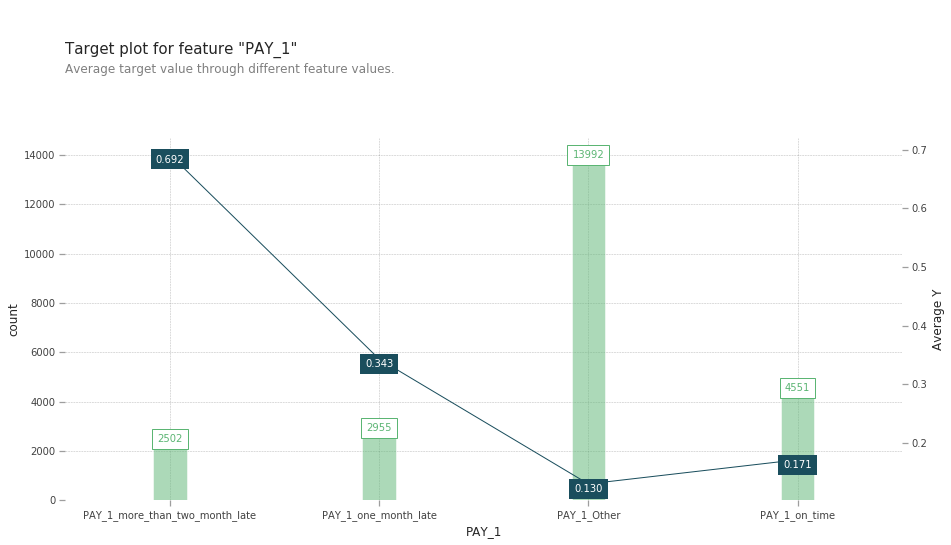

In [26]:
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=Train_data, feature=['PAY_1_more_than_two_month_late', 'PAY_1_one_month_late',
                            'PAY_1_Other', 'PAY_1_on_time'], feature_name='PAY_1',
target = target
)

What this plot indicates is this: for the 4 categories created from the orginal 'PAY_1' feature, the value in green denotes how many examples belong to that class, and the value in blue represents the avergage target value within that class. So for instance, in our case of binary target values of [0,1], the first value in blue, .692 means that within the 'PAY_1_more_than_two_month_late' class, roughly 69% of the target values in said class are indeed positive, or 1. The other classes have a lower amount of positive target values. We can show this for each of the 'PAY_2 : PAY_6' features. 

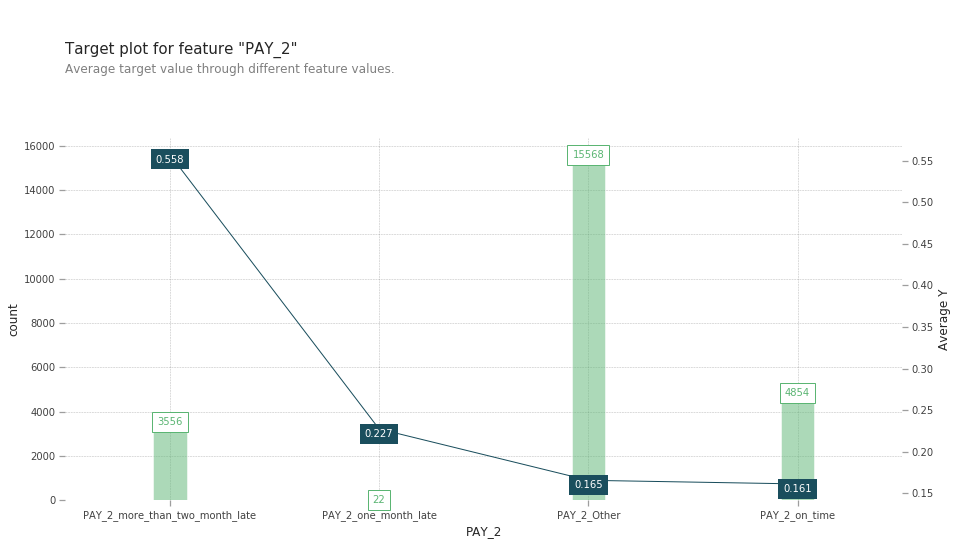

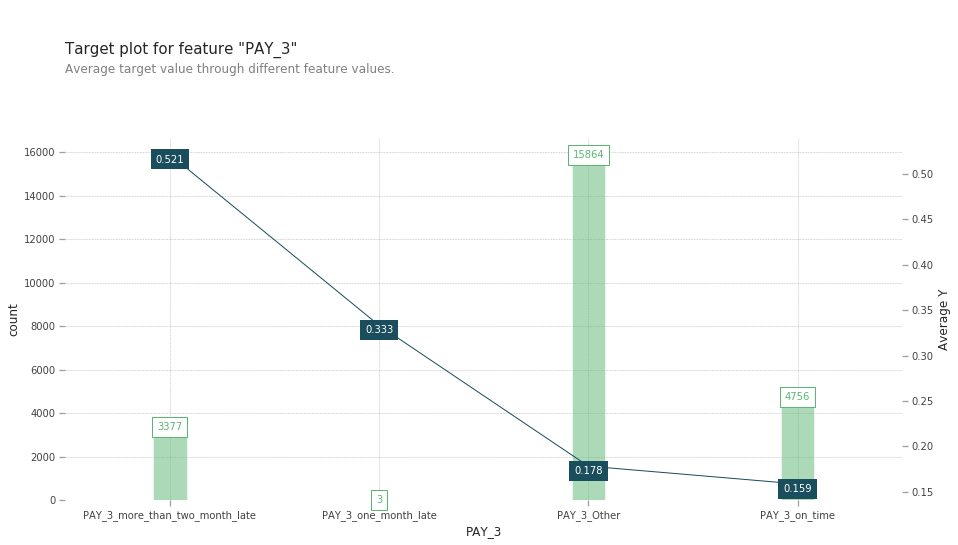

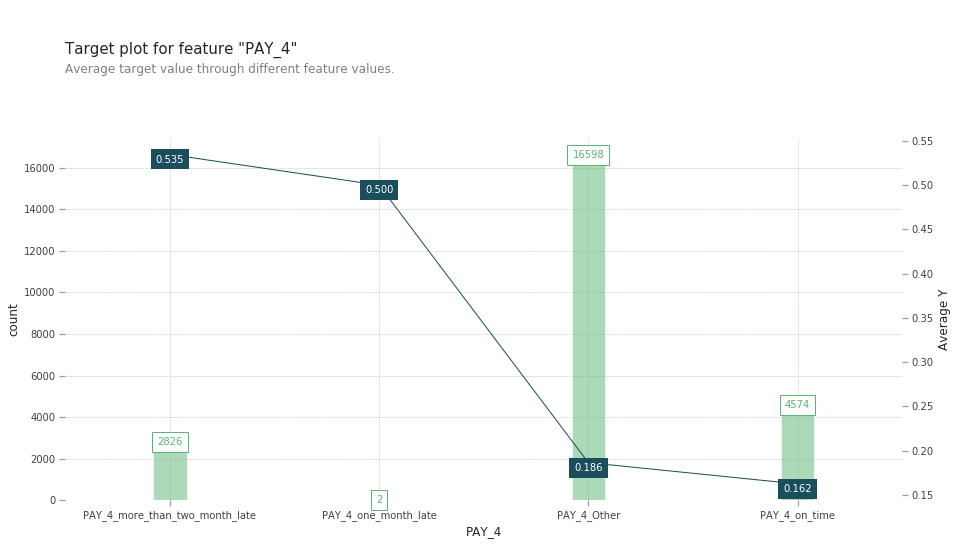

In [27]:
for n in  [2,3,4]:
    
    fig, axes, summary_df = info_plots.target_plot(
    df=Train_data, feature=[f'PAY_{n}_more_than_two_month_late', f'PAY_{n}_one_month_late',
                            f'PAY_{n}_Other', f'PAY_{n}_on_time'], feature_name=f'PAY_{n}',
target = target
)

It seems that each of these features follow a similar pattern: the 'more than two month late' payment timing is the only class that shows useful information regarding the liklihood of default; client's who fall into that first payment timing class are more likely to default, with the most previous time period payment of more than two months late being the most suggestive of default. 

We'll now move on to looking at PDP plots to show the marginal __???__

In [28]:
# need to fit our model to all data for comparative purposes

loaded_model.fit(Train_data[predictors], Train_data[target])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=3, missing=nan, n_estimators=190,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=3.4785949506037324,
       seed=2019, silent=True, subsample=0.5)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa3dd87e668>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa3ddb47b70>})

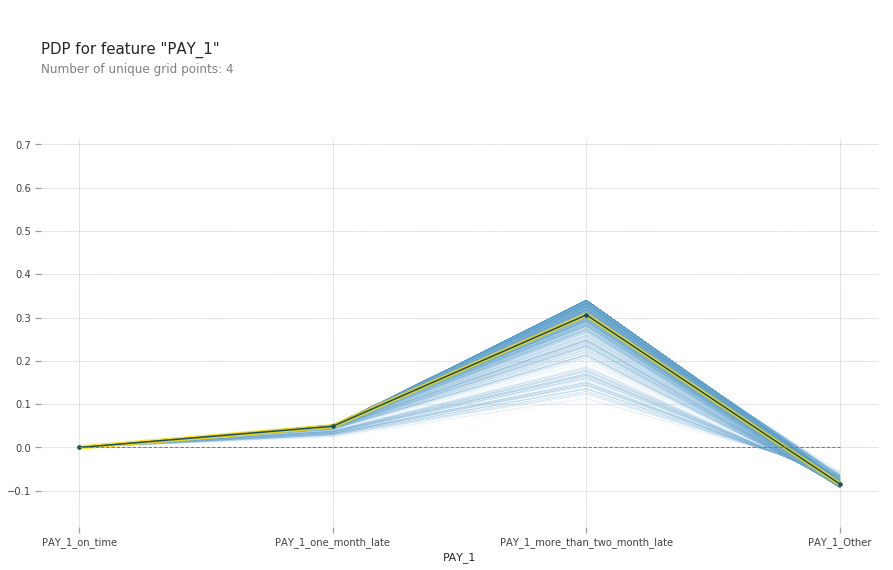

In [29]:
from pdpbox import pdp, get_dataset, info_plots

p = pdp.pdp_isolate(loaded_model, Train_data[predictors], predictors, feature = ['PAY_1_on_time', 'PAY_1_one_month_late','PAY_1_more_than_two_month_late', 'PAY_1_Other'])

pdp.pdp_plot(p, 'PAY_1',plot_lines=True, frac_to_plot=.05 )

The interpretaion of the chart is as follows: for the original feature, 'PAY_1', when encoded into these new logical features, the probability our model assigns for a specific example of being a postive target class is shown on the y-axis. Each blue line represents a single example from our data, and the yellow line denotes the average among all the examples. This means that for the average of data points, the probability of being classified in the positive class of the target is highest in the third class on the x-axis. We can see that as the payment timing gets more delayed, the probability of being predicted as defaulting increases. If an example belings to the 'PAY_1_Other' class, then the opposite occurs; that client is more likely to be predicted as non-defaulting. 

Now we'll look at the the other features that were encoded to see if the results from above hold true with these other features. 

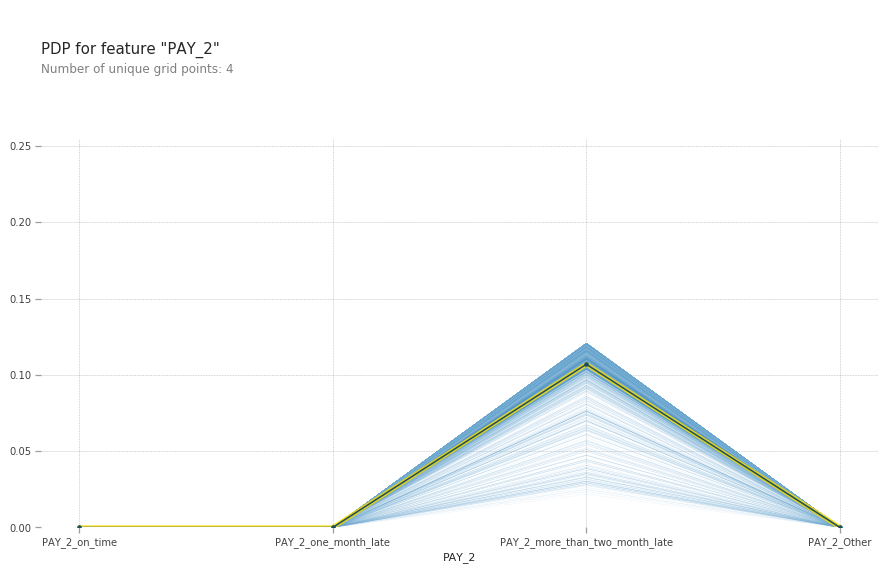

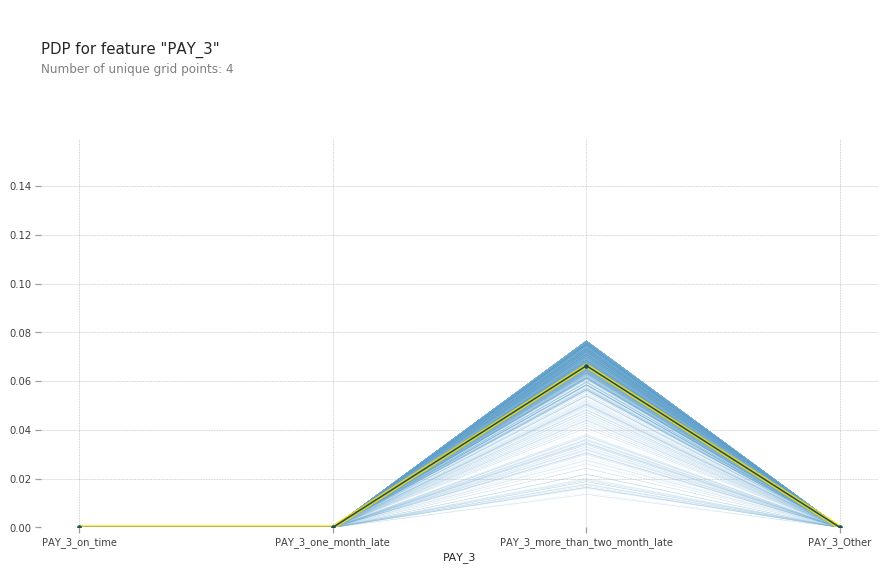

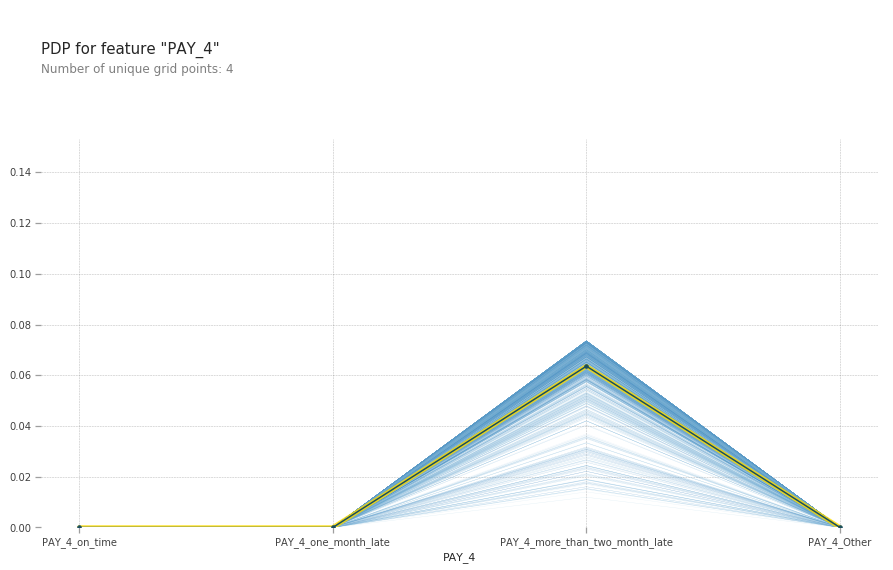

In [30]:
for n in  [2,3,4]:
    p = pdp.pdp_isolate(loaded_model, Train_data[predictors], predictors, 
                        feature = [f'PAY_{n}_on_time',f'PAY_{n}_one_month_late',
                                   f'PAY_{n}_more_than_two_month_late', f'PAY_{n}_Other' ])

    pdp.pdp_plot(p, f'PAY_{n}',plot_lines=True, frac_to_plot=.05 )
    


The results do not indicate much, since the magnitude of the probabilty assigned for these last features is much lower compared to 'PAY_1'. The only feature that shows some significant effect is 'PAY_2', which mimics the pattern in 'PAY_1', but to a lesser extent. Thus, it seems that the 'PAY_1_more_than_2_month_late' class has the strongest indication that a client may default out of any the classes/features that we have looked at. Taking a look back at the best predictors set in 'predictors_eli5', there is another features that are not binary in nature, 'PERCENT_OF_LIM_BAL2 '. Let's take a look at a PDP for this feature.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa3d99886d8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa3d9b7d9b0>})

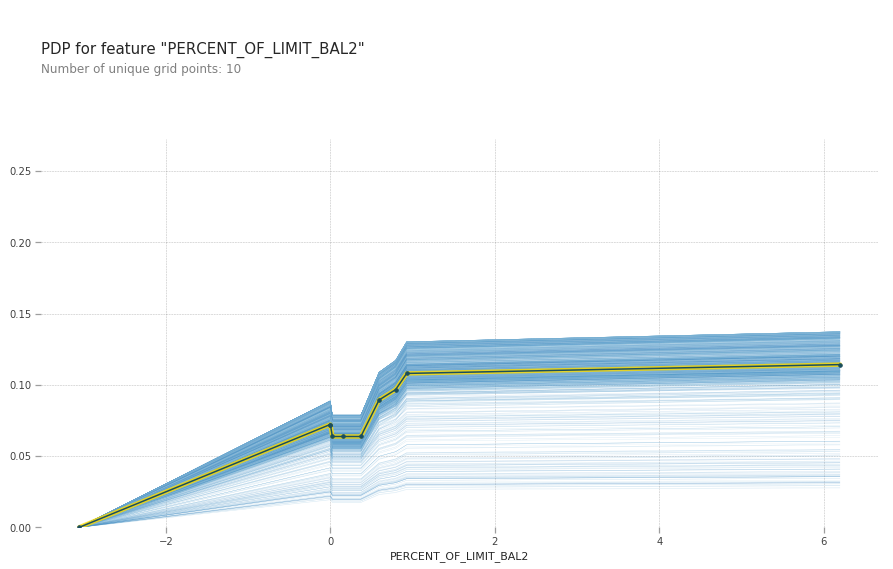

In [31]:
q = pdp.pdp_isolate(loaded_model, Train_data[predictors], predictors, feature = 'PERCENT_OF_LIMIT_BAL2')
pdp.pdp_plot(q, 'PERCENT_OF_LIMIT_BAL2',plot_lines=True, frac_to_plot=.05 )

NEED TO EXPLAIN THESE RESULTS AND WHY THEY ARE FUNKY. DATA OBVIOUSLY HAD EXAMPLES WHERE THE THE PAYMENT WAS MORE THAN THE BILL AMOUNT, HAD INSTANCES WHERE BILL AMOUNT AND/OR PAYMENT AMOUNT WAS NEGATIVE, SO THE OUTSTANDING BALANCE WAS NEGATIVE, WHICH IS BEING RATIOD AGAINST THE LIMIT BALANCE, RESULTING IN A NEGATIVE NUMBER. 

Now we'll look at shapley values...

EXPLAIN WHAT SHAP IS AND THE LIBRARY. EXPLAIN HOW IT CAN DO FEATURE IMPORTANCE, WHICH IS WHY WE'LL DO FEATURE IMPORTANCE ON ALL OF THE FEATURES FIRST, DO FEATURE SELECTION, THEN COMPARE RESULTS. 

In [32]:
import shap

#need to initialize javascript visualization 
#within the notebook
shap.initjs()

explainer = shap.TreeExplainer(loaded_model)

#shap_values = explainer.shap_values(Train_data[predictors])
#shap_values_test = explainer.shap_values(test_data[predictors])



In [0]:
shap_values = explainer.shap_values(Train_data[predictors])


In [0]:
shap_values_test = explainer.shap_values(test_data[predictors])

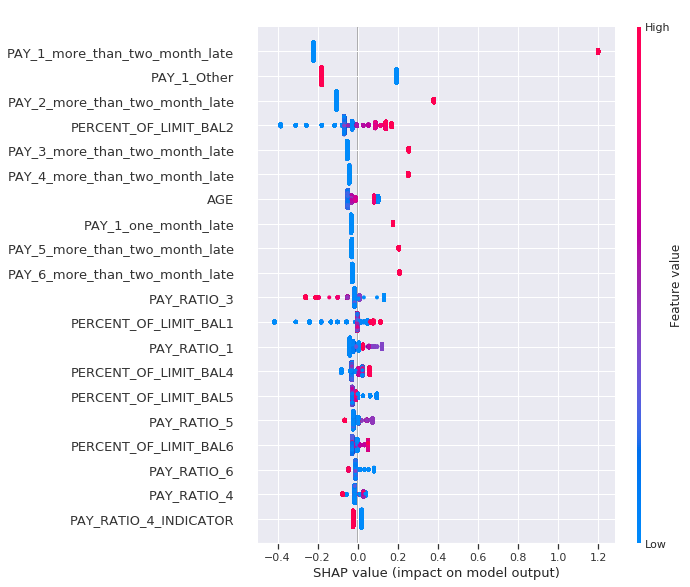

In [36]:
#let's look at shap feature importance
shap.summary_plot(shap_values, Train_data[predictors])

This plot shows us not only the ranking of feautes, but also how the values of those features affects the overall SHAP value. Looking at the plot, we can see the the feature name, and the color of the bar indicates the  magnitude of that feature. Many of these features are logical features, so a blue color indicates 0, and the red color indicates 1. The first feature, 'PAY_1_more_than_two_month_late' is indicated as the most important feature overall, like many of the other methods, and it too shows how the impact on the SHAP value is drastically increased for those client's with a value of 1 for said feature. 

One advantage of SHAP is that not only can we look at a global summary of features as it impacts our model on the whole, but we can also look locally at how the feature values for a single example impact the decision our model made for that particular example. 

Let's have a look at our first client in the test data set.

In [37]:
print("Model's prediction: " + str(y_pred[0]))
print("Actual value: " + str(test_data[target].iloc[0]))
print()
print("Feature Values for individual: ")
test_data[predictors].iloc[0,:]

Model's prediction: 1
Actual value: 1

Feature Values for individual: 


AGE                               46.000000
SEX_Female                         1.000000
SEX_Male                           0.000000
EDUCATION_Graduate School          0.000000
EDUCATION_Other                    1.000000
EDUCATION_University               0.000000
MARRIAGE_Married                   1.000000
MARRIAGE_Non-married               0.000000
PERCENT_OF_LIMIT_BAL1              0.386740
PERCENT_OF_LIMIT_BAL2              0.439830
PERCENT_OF_LIMIT_BAL3              0.450270
PERCENT_OF_LIMIT_BAL4              0.477590
PERCENT_OF_LIMIT_BAL5              0.448650
PERCENT_OF_LIMIT_BAL6              0.439300
PERCENT_OF_LIMIT_1_INDICATOR       1.000000
PERCENT_OF_LIMIT_2_INDICATOR       0.800000
PERCENT_OF_LIMIT_3_INDICATOR       0.600000
PERCENT_OF_LIMIT_4_INDICATOR       0.000000
PERCENT_OF_LIMIT_5_INDICATOR       0.000000
PAY_RATIO_1                        0.093734
PAY_RATIO_2                        0.043494
PAY_RATIO_3                        0.040488
PAY_RATIO_4                     

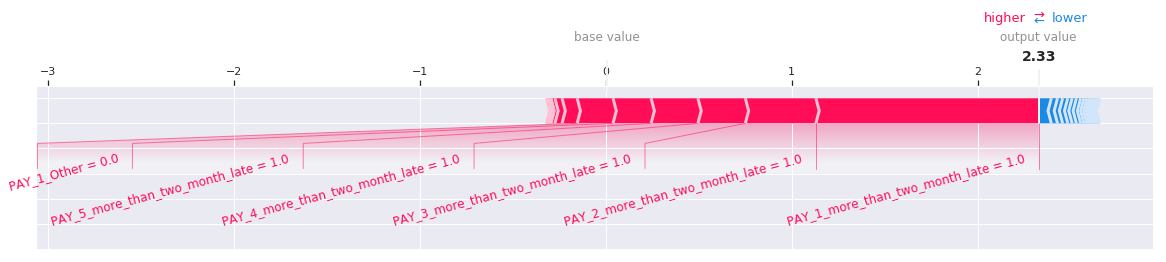

In [38]:
#build a shap.force_plot,
#which shows the effect of the feature value
#on the prediction for a single example
shap.force_plot(explainer.expected_value, shap_values_test[0,:], test_data[predictors].iloc[0,:], 
                text_rotation=15, matplotlib=True)

This plot shows us the contribution of certain features on the model's output. Featues in red push the SHAP output value higher, while those in blue push the output value lower. In the case of this client, she has many payment timing instances of being more than two months late, and the biggest contribution towards the model output value is the horizontal bar created by 'PAY_1_more_than_two_month_late'. This feature, coupled with the other 'more than two months late' payment timing help the model correctly predict that the client would default. 

Now let's look at a client who did not default.

In [39]:
print("Model's prediction: " + str(y_pred[1]))
print("Actual value: " + str(test_data[target].iloc[1]))
print()
print("Feature Values for individual: ")
test_data[predictors].iloc[1,:]

Model's prediction: 0
Actual value: 0

Feature Values for individual: 


AGE                               32.000000
SEX_Female                         1.000000
SEX_Male                           0.000000
EDUCATION_Graduate School          1.000000
EDUCATION_Other                    0.000000
EDUCATION_University               0.000000
MARRIAGE_Married                   0.000000
MARRIAGE_Non-married               1.000000
PERCENT_OF_LIMIT_BAL1              0.719275
PERCENT_OF_LIMIT_BAL2              0.745188
PERCENT_OF_LIMIT_BAL3              0.727912
PERCENT_OF_LIMIT_BAL4              0.740663
PERCENT_OF_LIMIT_BAL5              0.745725
PERCENT_OF_LIMIT_BAL6              0.736300
PERCENT_OF_LIMIT_1_INDICATOR       1.000000
PERCENT_OF_LIMIT_2_INDICATOR       0.000000
PERCENT_OF_LIMIT_3_INDICATOR       0.600000
PERCENT_OF_LIMIT_4_INDICATOR       0.400000
PERCENT_OF_LIMIT_5_INDICATOR       0.000000
PAY_RATIO_1                        0.049552
PAY_RATIO_2                        0.034027
PAY_RATIO_3                        0.038774
PAY_RATIO_4                     

In [40]:
shap.force_plot(explainer.expected_value, shap_values_test[1,:], test_data[predictors].iloc[1,:], 
                text_rotation=15, matplotlib=True)

As we can see, the results are different; the featues in blue are helping push the output value lower, which correspond's to the model correctly predicting the value of default/non-default. Now, let's use this plot once more to see an example where the model incorreclty predicted a positive, but was instead a non-default; a false positive. 

In [41]:
print("Model's prediction: " + str(y_pred[14]))
print("Actual value: " + str(test_data[target].iloc[14]))
print()
print("Feature Values for individual: ")
test_data[predictors].iloc[14,:]

Model's prediction: 1
Actual value: 0

Feature Values for individual: 


AGE                               34.000000
SEX_Female                         0.000000
SEX_Male                           1.000000
EDUCATION_Graduate School          0.000000
EDUCATION_Other                    1.000000
EDUCATION_University               0.000000
MARRIAGE_Married                   0.000000
MARRIAGE_Non-married               1.000000
PERCENT_OF_LIMIT_BAL1              0.659190
PERCENT_OF_LIMIT_BAL2              0.430105
PERCENT_OF_LIMIT_BAL3              0.968860
PERCENT_OF_LIMIT_BAL4              0.909780
PERCENT_OF_LIMIT_BAL5              0.961380
PERCENT_OF_LIMIT_BAL6              0.914335
PERCENT_OF_LIMIT_1_INDICATOR       0.000000
PERCENT_OF_LIMIT_2_INDICATOR       0.800000
PERCENT_OF_LIMIT_3_INDICATOR       0.000000
PERCENT_OF_LIMIT_4_INDICATOR       0.400000
PERCENT_OF_LIMIT_5_INDICATOR       0.000000
PAY_RATIO_1                        0.050425
PAY_RATIO_2                        0.394734
PAY_RATIO_3                        0.000026
PAY_RATIO_4                     

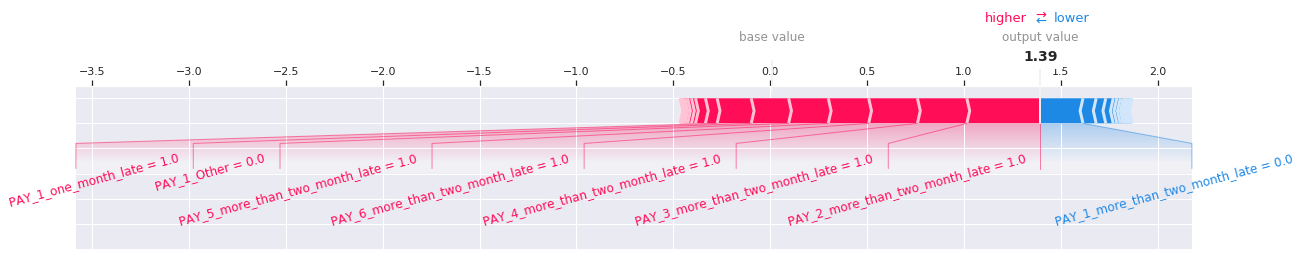

In [42]:
shap.force_plot(explainer.expected_value, shap_values_test[14,:], test_data[predictors].iloc[14,:], 
                text_rotation=15, matplotlib=True)

EXPLANATION NEEDED


Lastly, we'll see whether the features that SHAP find as important can improve the scores that were established by the predictors set found by the eli5 method. Looking at the feature importance plot above, we'll use features with the largest horizontal spread: 

In [45]:
predictors_shap = ['PAY_1_more_than_two_month_late', 'PAY_1_Other', 
                   'PAY_2_more_than_two_month_late', 'PERCENT_OF_LIMIT_BAL2',
                   'PAY_3_more_than_two_month_late', 'PAY_4_more_than_two_month_late',
                   'AGE', 'PAY_1_one_month_late', 'PAY_6_more_than_two_month_late',
                   'PAY_5_more_than_two_month_late', 'PAY_RATIO_3', 'PERCENT_OF_LIMIT_BAL1'
]

score_model(loaded_model, predictors_shap, target, Train_data, test_data)

Test Accuracy: 0.7838333333333334
Test AUC: 0.7086481015158248
Test F1: 0.5342908438061041
